In [1]:
# load csv into pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('C:\\Users\\Ronald\\Documents\\EECS_731\\Homework_6\\art_daily_jumpsdown.csv')
df.dropna()
df.head(10)

,timestamp,value
0,2014-04-01 00:00:00,18.090486
1,2014-04-01 00:05:00,20.359843
2,2014-04-01 00:10:00,21.105470
3,2014-04-01 00:15:00,21.151585
4,2014-04-01 00:20:00,18.137141
5,2014-04-01 00:25:00,21.625661
6,2014-04-01 00:30:00,21.673807
7,2014-04-01 00:35:00,20.245561
8,2014-04-01 00:40:00,19.928333
9,2014-04-01 00:45:00,18.179470


In [1]:
# feature engineer the data
# noticed that all the timestamp values have the same value for the month
# create a new column day since it is known that all the days occur in the same month
# day values will be float as a result of being total of day, hour, and minute features

In [2]:
from datetime import datetime
days = []
hours = []
minutes = []
for dates in df['timestamp']:
    date = datetime.strptime(dates, "%Y-%m-%d %H:%M:%S")
    day = date.day + (date.hour + date.minute/60)/24
    hour = date.hour + date.minute/60
    days.append(day)
    hours.append(hour)
    minutes.append(date.minute)
df.insert(1, 'day', days, allow_duplicates=False)
df.insert(2, 'hour', hours, allow_duplicates=False)
df.insert(3, 'minute', minutes, allow_duplicates=False)
df.to_csv('C:\\Users\\Ronald\\Documents\\EECS_731\\Homework_6\\model_data.csv')
df.head()

,timestamp,day,hour,minute,value
0,2014-04-01 00:00:00,1.000000,0.000000,0,18.090486
1,2014-04-01 00:05:00,1.003472,0.083333,5,20.359843
2,2014-04-01 00:10:00,1.006944,0.166667,10,21.105470
3,2014-04-01 00:15:00,1.010417,0.250000,15,21.151585
4,2014-04-01 00:20:00,1.013889,0.333333,20,18.137141


In [ ]:
# Plot moving averages of the values in order to see anomalies
# Source Code from https://www.datascience.com/blog/python-anomaly-detection

In [3]:
from __future__ import division
from itertools import count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
#   """ Helps in exploring the anamolies using stationary standard deviation
#     Args:
#     -----
#         y (pandas.Series): independent variable
#         window_size (int): rolling window size
#         sigma (int): value for standard deviation

#     Returns:
#     --------
#         a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
#         containing information about the points indentified as anomalies

#     """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='b')
    plt.xlim(0, 15)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.title('Anomaly Detection')
    plt.show()

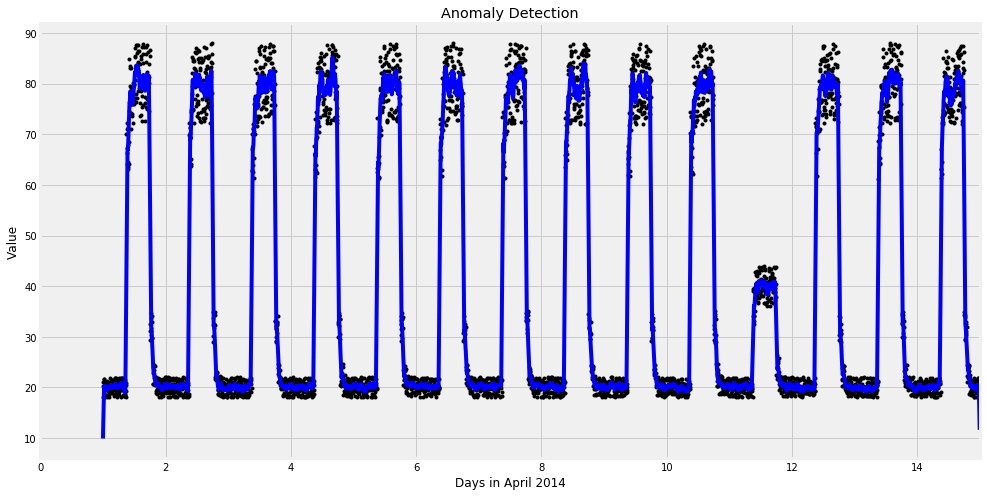

Information about the anomalies model:{'standard_deviation': 3.621, 'anomalies_dict': OrderedDict([(107, 20.4812123602), (108, 69.9717587639), (214, 86.5822793413), (215, 85.4819290545), (216, 32.5555775742), (217, 31.2133263199), (395, 18.3012801702), (396, 69.9171157856), (397, 72.2885760939), (503, 78.1832726016), (504, 33.6209645984), (683, 19.803277645799998), (684, 62.9653555979), (790, 82.5970166738), (791, 80.0170944047), (792, 33.0172790815), (971, 20.401418742), (972, 67.7586508444), (1079, 85.54824234189999), (1080, 32.4545754727), (1259, 19.8613569069), (1260, 73.26061417300001), (1366, 84.7465014389), (1367, 81.3803983246), (1368, 30.422641599000002), (1547, 19.6668931245), (1548, 71.9339767591), (1655, 82.0008256792), (1656, 30.661497946199997), (1657, 29.2177504523), (1834, 18.9882665817), (1835, 21.502191489899996), (1836, 73.4262783623), (1943, 87.05493418889999), (1944, 33.3655459366), (2122, 18.8628939619), (2123, 21.0153050468), (2124, 73.1864312682), (2231, 85.6995

In [4]:
# Use 'day' and 'value' features from the dataset
x = df['day']
Y = df['value']

# Plot results
plot_results(x, y=Y, window_size=10, text_xlabel="Days in April 2014", sigma_value=3,
             text_ylabel="Value")
events = explain_anomalies(Y, window_size=5, sigma=3)

# Display anomaly dict
print("Information about the anomalies model:{}".format(events))

In [ ]:
# Can see that there is an anomaly around the 11th day of April 
# Max value is significantly lower on the 11th day with respect to the maximum value of the other days

In [ ]:
# Plotting Interquartile Range (IQR) of the data also allows for anomaly detection
# model code from 
# http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
# #sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

In [5]:
import matplotlib as mpl
from matplotlib import cm
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import RobustScaler

X_full, y_full = df.drop(['timestamp','value'], axis=1).values, df['value']

# Take only 2 features to make visualization easier
# Feature of 0 has a long tail distribution.
# Feature 5 has a few but very large outliers.

X = X_full[:,[0,1]]
distribution = [('Data after robust scaling', RobustScaler(quantile_range=(25, 75)).fit_transform(X))]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, 'plasma_r', cm.hot_r)

# create plot axes
def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)

# plot distribution function
def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

In [6]:
# construct the plot
def make_plot(item_idx):
    title, X = distribution[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(axarr[0], X, y, hist_nbins=200,
                      x0_label="Day in April 2014",
                      x1_label="Value",
                      title="Full Data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], X[non_outliers_mask], y[non_outliers_mask],
                      hist_nbins=50,
                      x0_label="Day in April 2014",
                      x1_label="Value",
                      title="Full Data")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of y')

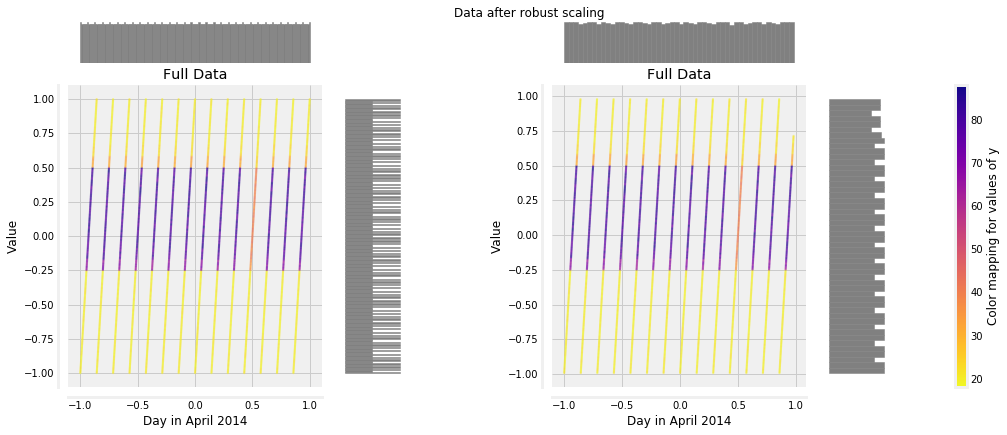

In [7]:
# plot the data 
make_plot(0)

In [8]:
# plot gives a clear visualization of outliers
# can again see that the 11th day of April is an outlier
# the plot shows that all of the other days have a similar purple color in middle region, while the 11th day
# has an orange color in the middle region

In [ ]:
# Discussion

# dataset is a decent size, but only has two features
# can use feature engineering on the 'timestamp' feature to create new features
# the moving average model delivers a good detection of the outliers in the dataframe
# the interquartile range (IQR) model also gives a nice visualization of the values overall and 
# provides reliable anomaly detection